In [14]:
from astropy.modeling import models, Fittable1DModel, Parameter
from astropy.modeling import fitting
import astropy.units as u
import astropy.constants as const

from spectacle.spectrum import SpectrumModel

import numpy as np
import matplotlib.pyplot as plt

In [15]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = [8, 16]
# plt.rcParams["figure.dpi"] = 80

## Control Spectrum

This spectrum acts as the standard to which the dynamic spectrum will be compared in the correlation metrics.

In [16]:
wavelength = np.linspace(1000, 2000, 1001) * u.Angstrom
velocity = np.linspace(-200, 800, 201) * u.Unit('km/s')

In [27]:
# Define the parameter ranges
v_doppler_range = np.logspace(6, 7, 3) * u.Unit('cm/s')
column_density_range = 10 ** np.linspace(13, 14, 3) * u.Unit('1/cm2')
delta_lambda_range = np.linspace(0, 2, 100) * u.Angstrom
delta_v_range = np.linspace(0, 400, 100) * u.Unit('km/s')

def generate(corr_func):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
    
    ax1.set_xlabel("$\Delta v$ [km/s]")
    ax1.set_ylabel("Correlation using Flux")
    
    ax2.set_xlabel("$\Delta v$ [km/s]")
    ax2.set_ylabel("Correlation using Tau")
    
    ax3.set_xlabel("$\Delta v$ [km/s]")
    ax3.set_ylabel("Correlation using Flux Decrement")
    
    ax4.set_xlabel("Velocity [km/s]")
    ax4.set_ylabel("Normalized Flux Decrement")
    
    def perform_variations(v_dop, col_dens):
        corr, corr_tau, corr_dec = [], [], []
        
        line1 = dict(lambda_0=1.21567010E+03 * u.Angstrom,
                     gamma=6.2650000e+08, 
                     f_value=4.1640E-01,
                     v_doppler=v_doppler_range[1],
                     column_density=column_density_range[1])

        spectrum1 = SpectrumModel(center=line1['lambda_0']).add_line(**line1)

        for dv in delta_v_range:
            line2 = dict(lambda_0=1.21567010E+03 * u.Angstrom,
                         gamma=6.2650000e+08, 
                         f_value=4.1640E-01,
                         v_doppler=v_dop,
                         column_density=col_dens,
                         delta_v=dv)
            
            spectrum2 = SpectrumModel(center=line2['lambda_0']).add_line(**line2)

            corr.append(corr_func(spectrum1.flux(velocity), 
                                  spectrum2.flux(velocity)))

            corr_tau.append(corr_func(spectrum1.tau(velocity), 
                                      spectrum2.tau(velocity)))

            corr_dec.append(corr_func(spectrum1.flux_decrement(velocity), 
                                      spectrum2.flux_decrement(velocity)))

        ax4.step(velocity, spectrum1.flux_decrement(velocity))
        ax4.step(velocity, spectrum2.flux_decrement(velocity))
        
        return corr, corr_tau, corr_dec
        
    colors = ['b', 'r', 'g']
    line_styles = ['-', '--', '-.']
    
    for i, v_dop in enumerate(v_doppler_range):
        for j, col_dens in enumerate(column_density_range):
            corr, corr_tau, corr_dec = perform_variations(v_dop, col_dens)
            
            ax1.plot(delta_v_range, corr, label="{:g} {:g}".format(v_dop, col_dens), 
                     color=colors[i], linestyle=line_styles[j])
            ax2.plot(delta_v_range, corr_tau, label="{:g} {:g}".format(v_dop, col_dens), 
                     color=colors[i], linestyle=line_styles[j])
            ax3.plot(delta_v_range, corr_dec, label="{:g} {:g}".format(v_dop, col_dens), 
                     color=colors[i], linestyle=line_styles[j])
        
    ax1.legend(loc=0)

<IPython.core.display.Javascript object>


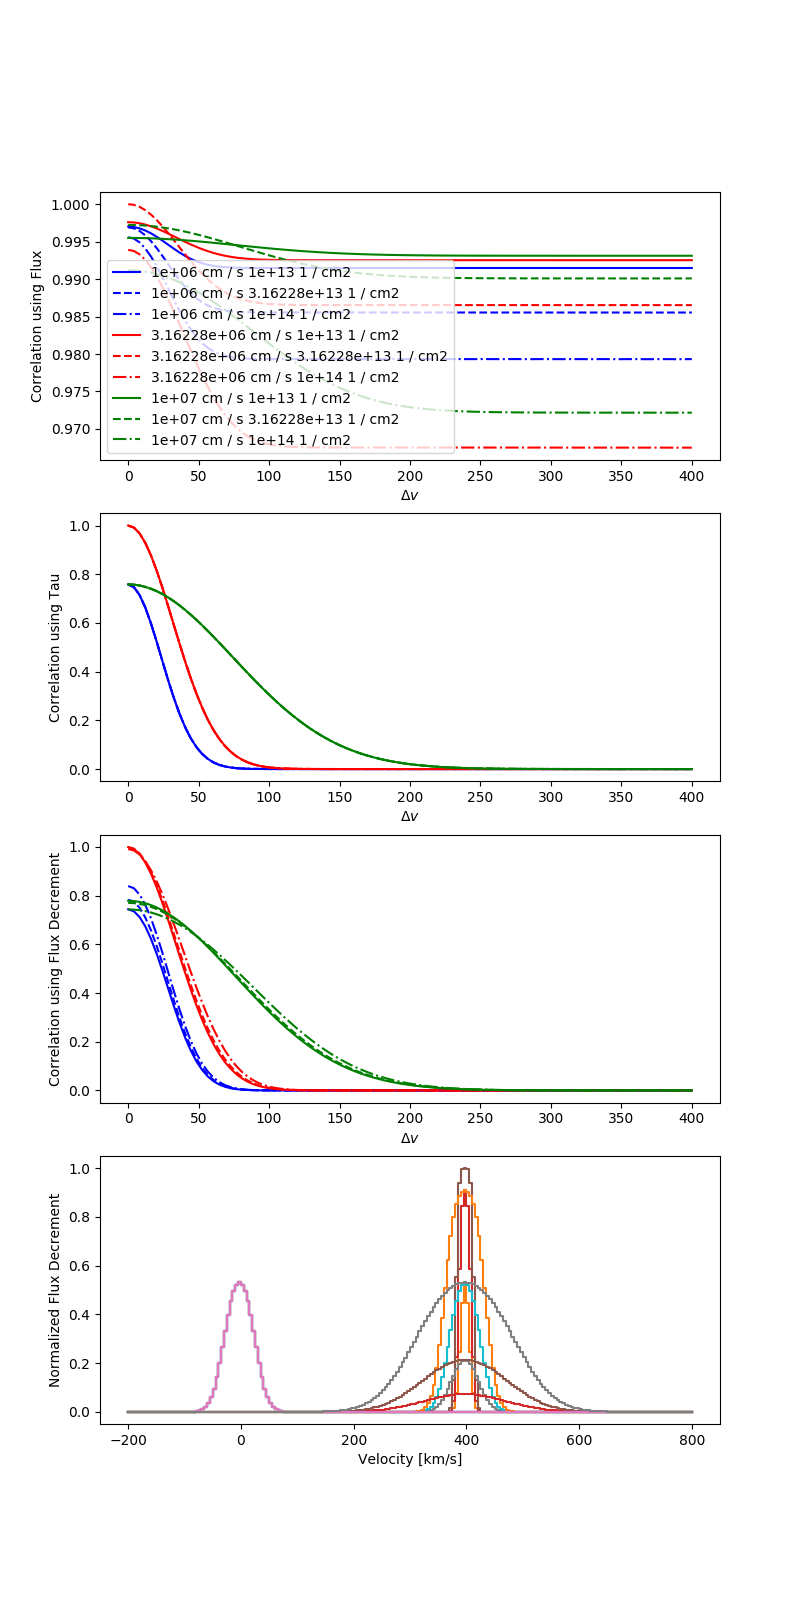

In [28]:
from spectacle.metrics import Epsilon
corr_list = generate(Epsilon())

<IPython.core.display.Javascript object>


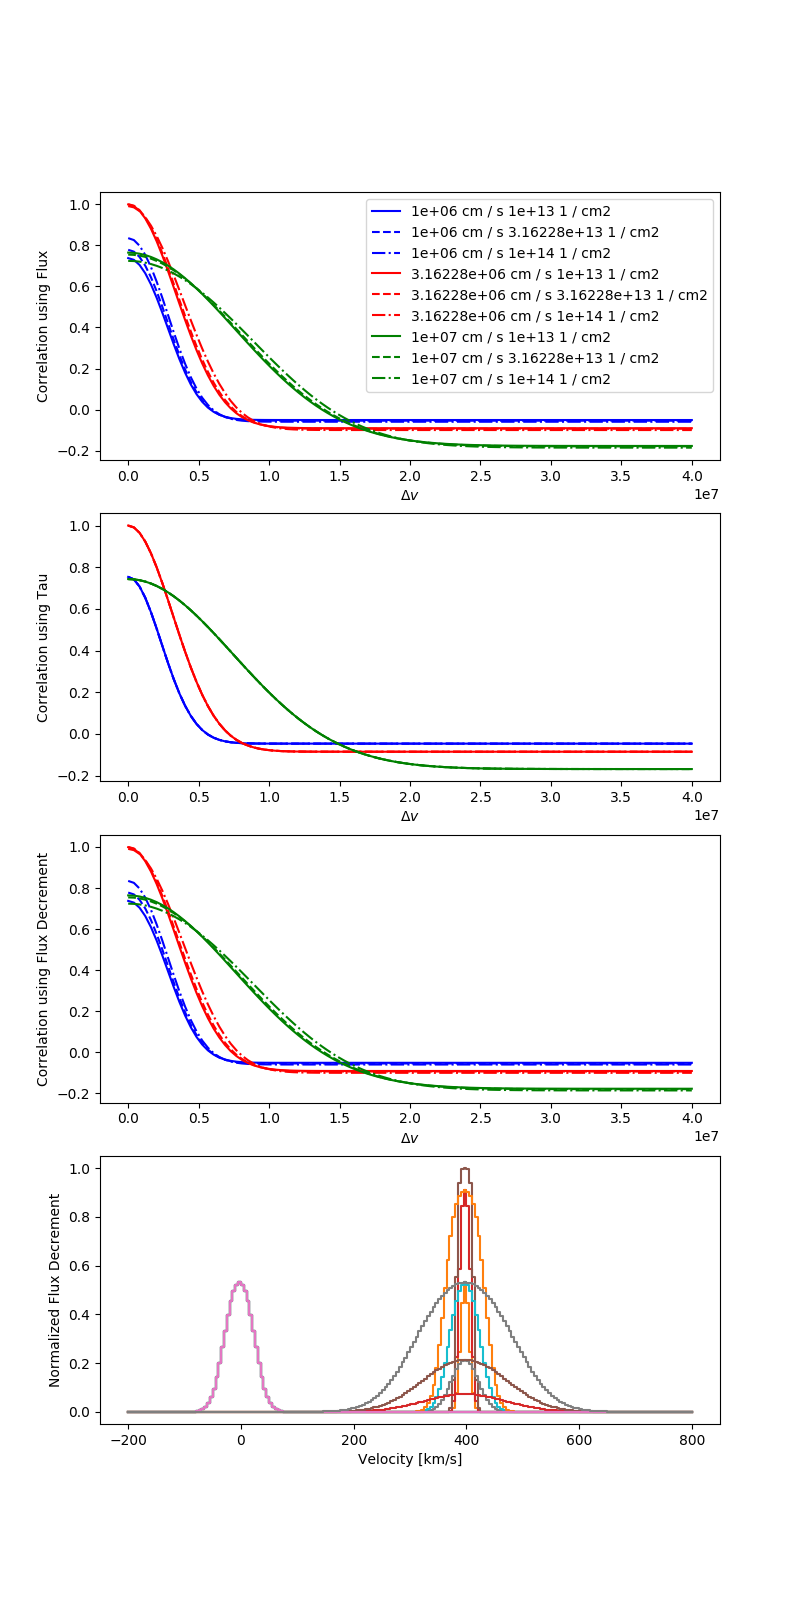

In [19]:
from spectacle.metrics import CrossCorrelate
corr_list = generate(CrossCorrelate())

<IPython.core.display.Javascript object>


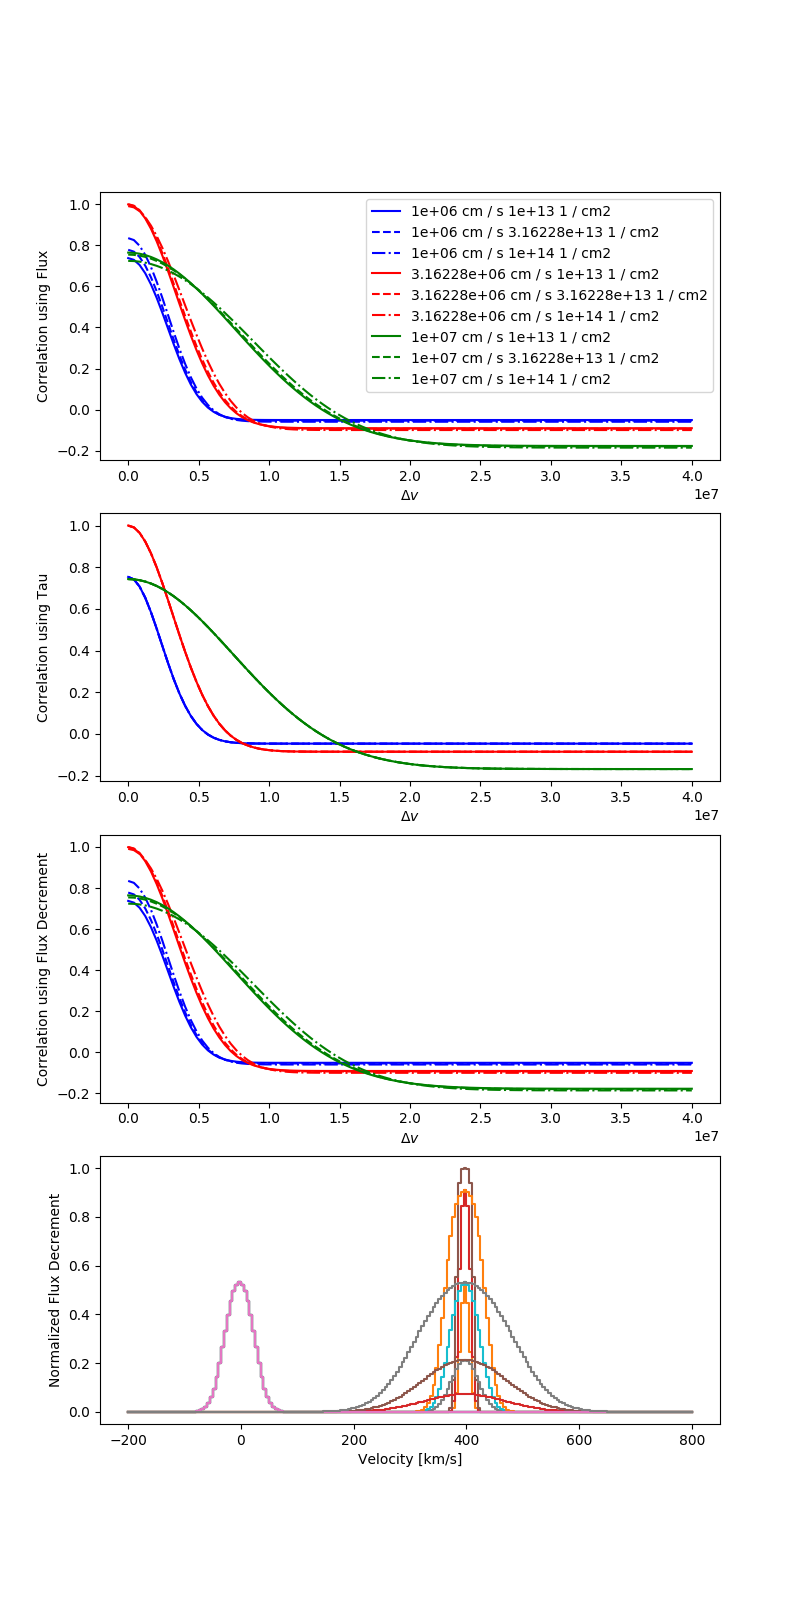

In [20]:
from spectacle.metrics import CorrMatrixCoeff
corr_list = generate(CorrMatrixCoeff())

<IPython.core.display.Javascript object>


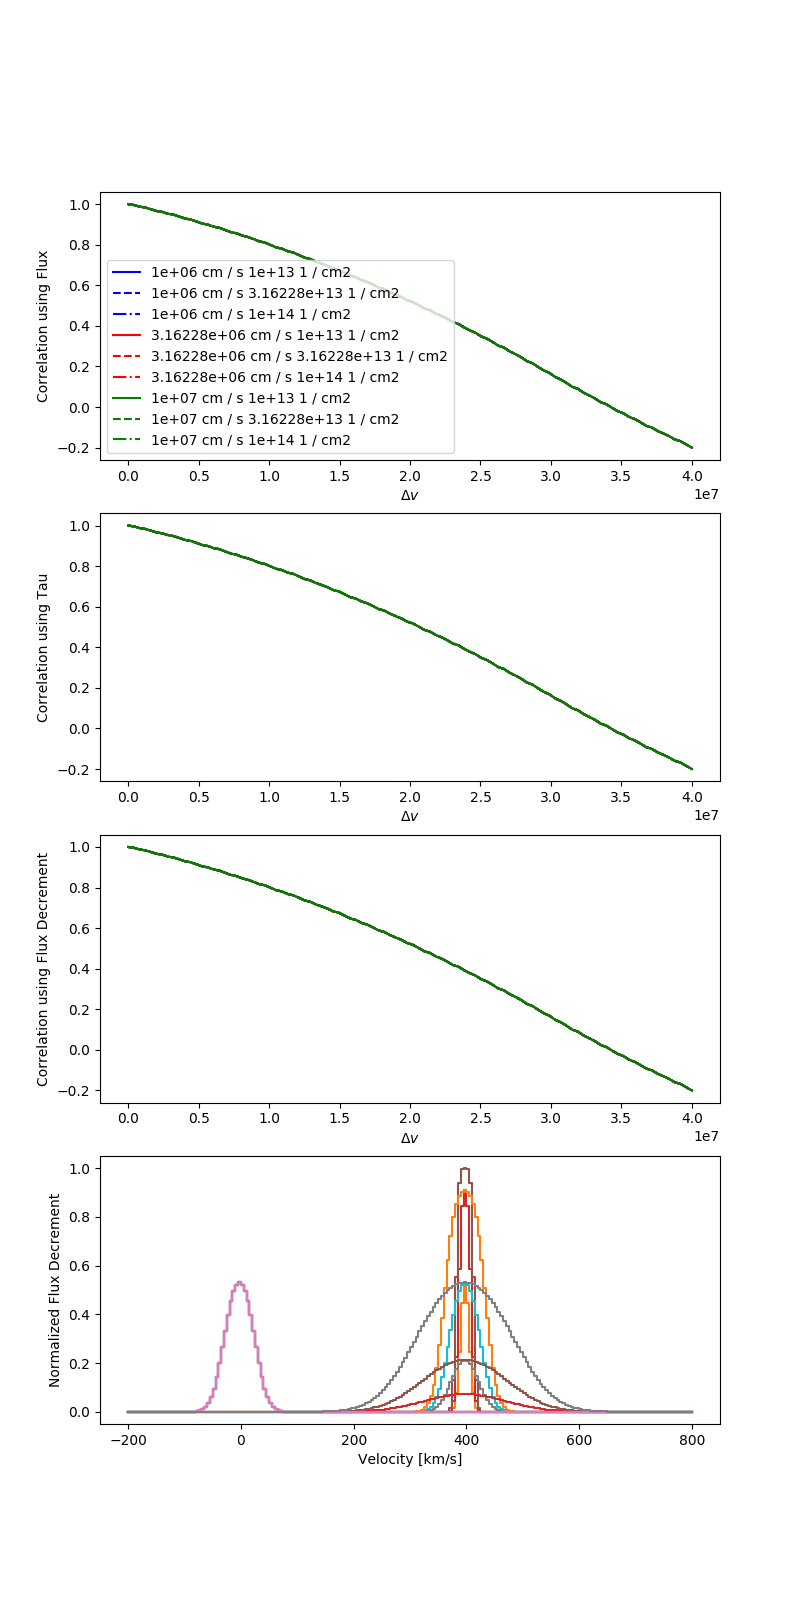

In [21]:
from spectacle.metrics import KendallsTau
corr_list = generate(KendallsTau())

<IPython.core.display.Javascript object>


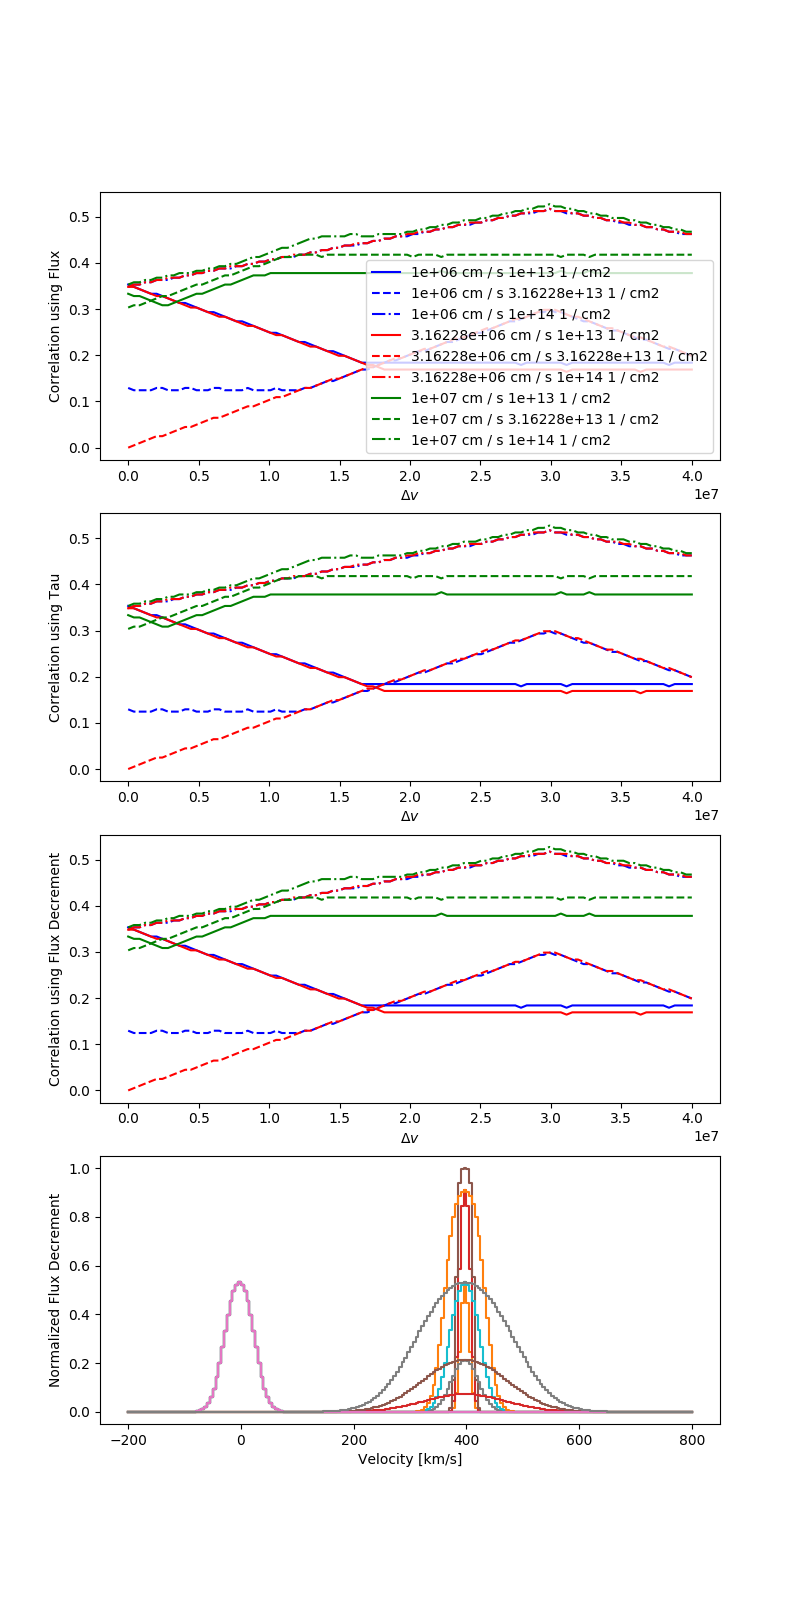

In [22]:
from spectacle.metrics import KolmogorovSmirnov
corr_list = generate(KolmogorovSmirnov())

<IPython.core.display.Javascript object>


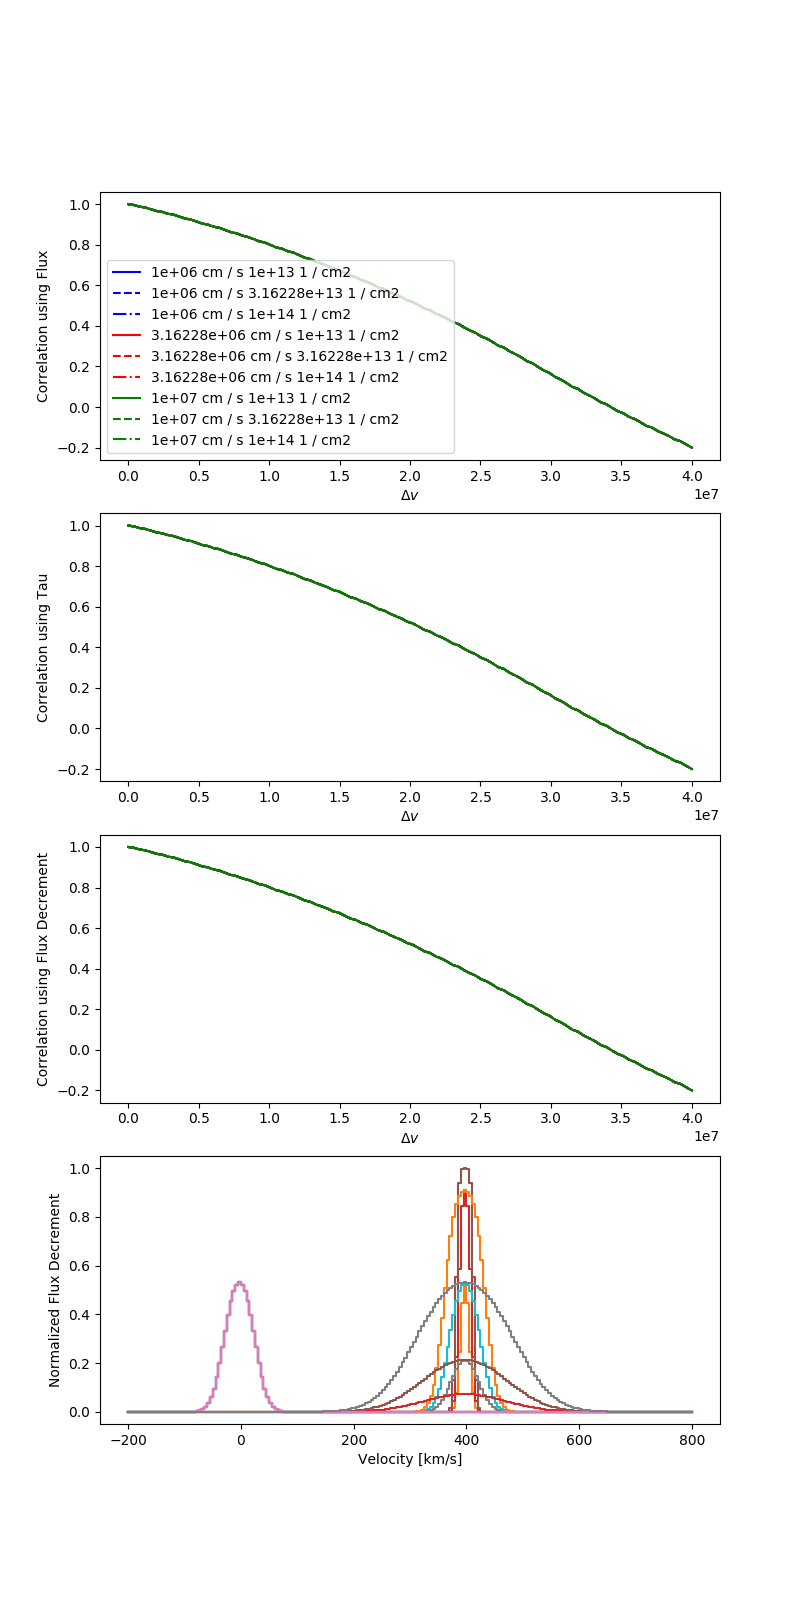

In [23]:
from spectacle.metrics import AndersonDarling
corr_list = generate(AndersonDarling())